In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt# Noise block
import numpy as np
from collections import Counter
import pickle
from collections import defaultdict
import torch
sns.set()

In [10]:
def load_dunnhumby():
    print('loading csv')
    transactions = pd.read_csv(DATA_PATH + 'transaction_data.csv', dtype={'PRODUCT_ID': str})
    transactions['QUANTITY'] = transactions['QUANTITY'].map(lambda x: x if x > 0.1 else 1)
    transactions['price'] = transactions.SALES_VALUE / transactions.QUANTITY
    prices = transactions[['price', 'PRODUCT_ID']].groupby('PRODUCT_ID').median().to_dict()['price']
    
    print('creating products')
    products_df = pd.read_csv(DATA_PATH + 'product.csv', dtype={'PRODUCT_ID': str})
    products = []
    all_used_barcodes = transactions[['PRODUCT_ID', 'price']].groupby('PRODUCT_ID').count()
    all_used_barcodes = sorted(all_used_barcodes[all_used_barcodes.price > MIN_USAGES].index)
    barcode_to_index = {}
    for i, row in enumerate(products_df.set_index('PRODUCT_ID').loc[all_used_barcodes].reset_index().iterrows()):
        products.append(Product(row, prices, i))
        barcode_to_index[products[-1].barcode] = i
    
    print('creating transactions')
    transactions_list = []
    total_items=0
    prev_id = -1
    for row in transactions.iterrows():
        row = row[1]
        u_id = str(int(row[0]))
        t_id = str(int(row[1]))
        barcode = str(int(row[3]))
        quantity = row[4]
        price = row[5]

        if t_id != prev_id:
            transactions_list.append(Transaction(t_id, u_id))
            prev_id = t_id
        if barcode in barcode_to_index.keys():
            #transactions_list[-1].barcodes.append(barcode)
            transactions_list[-1].indices.append(barcode_to_index[barcode])
            #transactions_list[-1].quantities.append(quantity)
            #transactions_list[-1].prices.append(price)
            products[barcode_to_index[barcode]].usages += 1
            total_items += 1
        
    return transactions_list, products, total_items

In [11]:
def load_strauss(create=False):
    dtype = {
    'OBJECT_ID': 'category',
    'USER_ID': 'category',
    'BARCODE': 'category',
    'DSC_ITEM': 'category',
    'INVOICE_SUM': 'float16',
    'QUANTITY': 'float16',
    'ITEM_PRICE': 'float16',
    'INV_BUYING_DATE': 'category'
    }

    #users = pd.read_csv('Q://users.csv', encoding='cp1255')
    products_df = pd.read_csv('Q://products.csv', encoding='cp1255', dtype='object')
    products_df = products_df.set_index('ITEM_ID')
    products = []
    if not create:
        transactions = pd.read_pickle('Q://transactions.pkl')
        transactions.BARCODE = transactions.BARCODE.astype('int64').astype('object').map(lambda x: str(x)).astype('category')
    else:
        transactions = pd.read_csv('Q://export.csv', encoding='cp1255', dtype=dtype, usecols=list(dtype.keys()), index_col='OBJECT_ID')
        transactions.loc[transactions.ITEM_PRICE.isna(), 'ITEM_PRICE'] = 0
        transactions.BARCODE = transactions.BARCODE.cat.add_categories(-111).fillna(-111)
        transactions['KNOWN_PRODUCT'] = transactions['BARCODE'].map(lambda x: int(x) in products_df.index).astype(bool)
        transactions = transactions[transactions.KNOWN_PRODUCT]
        transactions.to_pickle('Q://transactions.pkl' ,compression=None)
    print('loaded transactions df', transactions.reset_index().OBJECT_ID.nunique())
    
    transactions['QUANTITY'] = transactions['QUANTITY'].map(lambda x: x if x > 0.1 else 1)
    transactions['price'] = transactions.ITEM_PRICE / transactions.QUANTITY
    prices = transactions[['price', 'BARCODE']].groupby('BARCODE').median().to_dict()['price']
    
    all_used_barcodes = transactions[['BARCODE', 'price']].groupby('BARCODE').count()
    all_used_barcodes = sorted(all_used_barcodes[all_used_barcodes.price > MIN_USAGES].index)
    barcode_to_index = {}
    for i,row in enumerate(products_df.loc[all_used_barcodes].iterrows()):
        products.append(Product(row, prices, i))
        barcode_to_index[products[-1].barcode] = i
    print('created products')
    
    transactions_dict = {}
    total_items=0
    for barcode, t_id, quantity, item_price, u_id, total in transactions.reset_index()[['BARCODE', 'OBJECT_ID', 'QUANTITY', 'ITEM_PRICE', 'USER_ID', 'INVOICE_SUM']].values:
        if t_id not in transactions_dict.keys():
            transactions_dict[t_id] = Transaction(t_id, u_id, total)
            if len(transactions_dict) % 500000 == 0:
                print(len(transactions_dict))
        if barcode in barcode_to_index.keys():
            t = transactions_dict[t_id]
            #transactions_list[-1].barcodes.append(barcode)
            t.indices.append(barcode_to_index[barcode])
            #t.quantities.append(quantity)
            #transactions_list[-1].prices.append(item_price)
            products[barcode_to_index[barcode]].usages += 1
            total_items += 1
    for t in transactions_dict.values():
        t.indices = list(set(t.indices))
    return list(transactions_dict.values()), products, total_items

# Loading and indexing of products

In [12]:
DATASET = 'dunnhumby'
DATA_PATH = './data/dunn/'
MIN_USAGES = 5
DEPTH = 5 if DATASET == 'strauss' else 4
VIZ_STATS = True

if DATASET == 'strauss':
    transactions, products, total_items = load_strauss()
else:
    transactions, products, total_items = load_dunnhumby()

loading csv
creating products
creating transactions


In [13]:
# For each level of hierarchy count unique names, sort and give indices
LEVEL_SIZE = [0 for i in range(DEPTH)]
hierarchy_names = [set() for i in range(DEPTH)]
for product in products:
    for i in range(DEPTH):
        hierarchy_names[i].add(product.hierarchy_names[i])

GROUP_INDEX_OF = {} # Dict [name of hierarchy group/barcode: relative index in relevant hierarchy level]
INDEX_OF = {} # Dict {name of hierarchy group/barcode: absolute index in concatenated vector}
offset = 0
for i in range(DEPTH):
    for index, name in enumerate(sorted(hierarchy_names[i])):
        GROUP_INDEX_OF[name] = index
        INDEX_OF[name] = index + offset
    offset += len(hierarchy_names[i])
    LEVEL_SIZE[i] = len(hierarchy_names[i])

In [14]:
# Update products with relevant indices
for product in products:
    product.hierarchy_indices = [INDEX_OF[x] for x in product.hierarchy_names]
    product.hierarchy_names = []

In [15]:
# Prepare subsampling frequency and neg sampling frequency
freq = np.array([x.usages for x in products])
freq = freq/total_items
alpha_freq = np.power(freq, 0.75)
alpha_freq /= alpha_freq.sum()

c = 1e-5 if DATASET=='strauss' else 1e-4

subsample_freq = [max(1- (c / _freq) ** 0.5 - c / _freq, 0) for _freq in freq] 

NEGATIVE_SAMPLING_PROBABILITY = alpha_freq
DOWNSAMPLE_PROBABILITY = subsample_freq 

In [18]:
with open(backup_path, 'wb') as f:
    pickle.dump([transactions, products, GROUP_INDEX_OF, INDEX_OF, NEGATIVE_SAMPLING_PROBABILITY, DOWNSAMPLE_PROBABILITY, LEVEL_SIZE, DEPTH], f)

# Some data vizualizations

In [19]:
print('TOTAL USERS:', len(set([x.user_id for x in transactions])))
print('TOTAL TRANSACTIONS: {}. MEDIAN TRANSACTION SIZE: {}. AVERAGE MONEY SPENT: {:.1f}'.format(len(transactions), 
                                                                                            np.median([len(x.indices) for x in transactions]), 
                                                                                            np.mean([x.total for x in transactions])))
print('TOTAL PRODUCTS: {}. MEDIAN PRODUCT PRICE: {}. MEDIAN PURCHASES: {}'.format(len(products),
                                                                                 np.median([x.price for x in products]),
                                                                                 np.median([x.usages for x in products])))

TOTAL USERS: 2500
TOTAL TRANSACTIONS: 276484. MEDIAN TRANSACTION SIZE: 4.0. AVERAGE MONEY SPENT: 0.0
TOTAL PRODUCTS: 34093. MEDIAN PRODUCT PRICE: 2.5. MEDIAN PURCHASES: 23.0


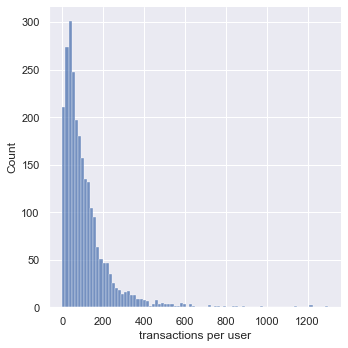

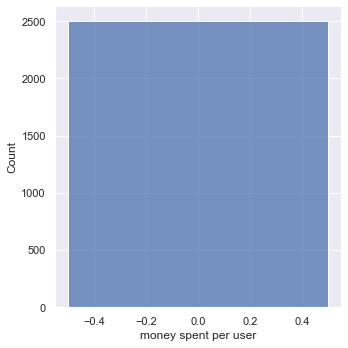

In [22]:
users_spent_money = defaultdict(int)
users_transactions = defaultdict(int)
for transaction in transactions:
    user = transaction.user_id
    users_transactions[user] += 1
    users_spent_money[user] += transaction.total 
df = pd.DataFrame(users_transactions.items(), columns=['user', 'transactions per user'])
sns.displot(df['transactions per user'])
plt.show()
df = pd.DataFrame(users_spent_money.items(), columns=['user', 'money spent per user'])
sns.displot(df['money spent per user'])
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
Dataset has 0 variance; skipping density estimate.


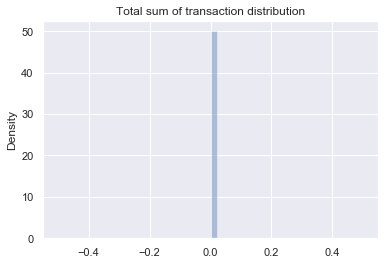

In [24]:
p = sns.distplot([x.total for x in transactions if x.total < 1000])
#p.set_xlim(0,800)
p.set_title('Total sum of transaction distribution')
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Log2 of product usage(number of transactions appeared in) distribution')

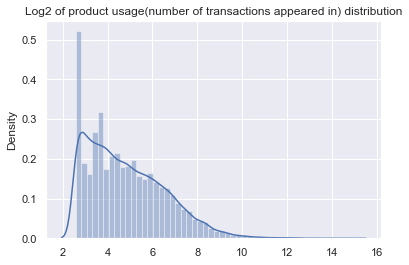

In [25]:
p = sns.distplot(np.log2([x.usages for x in products]))
p.set_title('Log2 of product usage(number of transactions appeared in) distribution')

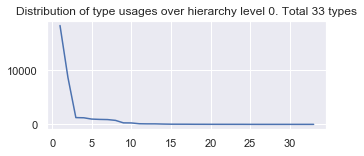

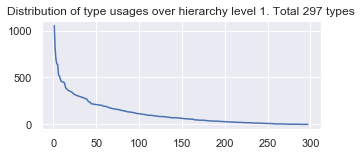

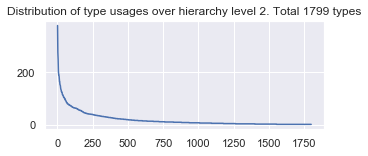

In [26]:
for level in range(DEPTH-1): # no need in barcode count
    c = Counter([x.hierarchy_indices[level] for x in products])
    plt.figure(figsize=(5,2))
    p = sns.lineplot(x=list(range(1, 1+ len(c.values()))), y=sorted(c.values(), reverse=True))
    p.set_title('Distribution of type usages over hierarchy level {}. Total {} types'.format(level, len(c)))
    plt.show()
